<a href="https://colab.research.google.com/github/pitthexai/IEEE_ICHI_EBAICWorkshop/blob/main/EBAIC2024_Workshop/Track03_Fairlearn/EBAIC2024_Fairlearn_Diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EBAIC 2024 Track III: Fairlearn: An open-source package to improve fairness of AI

The field of fairness in AI systems is an interdisciplinary area of research and practice focused on understanding and mitigating the negative impacts of AI on society. In this tutorial, we utilize Fairlearn -- an open-source library designed to help improve the fairness of AI systems. In this tutorial, we consider an automated system for recommending patients for high-risk care management programs

## Dataset and Task
Using a dataset included with the Fairlearn library, we will be working with a clincial dataset of containing re-admissions over a ten-year period (1998-2008) for diabetic patients across 130 different hospitals within the US. Features included within the dataset include:

- demographics,
- diagnoses,
- diabetic medications,
- number of visits in the year preceding the encounter,
- payer information,
- whether the patient was readmitted after release,
- whether the readmission occurred within 30 days of the release

Out goal is to develop a classification model that decides whether the patients should be suggested to their primary care physicians for an enrollment into a high-risk care management program.

## Package Setup

In [ ]:
!pip install --upgrade fairlearn==0.10.0
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: fairlearn
    Found existing installation: fairlearn 0.8.0
    Uninstalling fairlearn-0.8.0:
      Successfully uninstalled fairlearn-0.8.0


ERROR: Operation cancelled by user


In [1]:
import numpy as np
import pandas as pd

pd.set_option("display.float_format", "{:.3f}".format)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve)
from sklearn import set_config

set_config(display="diagram")

In [3]:
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.datasets import fetch_diabetes_hospital
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

## Data Exploration

The first step is to explore the data provided for any fairness issues that may occur. Specifically, we look at:
1. sample sizes of different demographic groups, and in particular different racial groups
2. balance of the class labels

### Loading the Dataset
We first load the dataset using the Fairlearn library. We then construct our target column ```readmit_30_days```.

In [11]:
diabetes_data = fetch_diabetes_hospital()

In [15]:
diabetes_df = diabetes_data.data

In [20]:
diabetes_df["readmit_30_days"] = np.where(diabetes_df.readmitted == "<30", 1, 0)

### Group Sizes

For assessing fairness, a key data characteristic is the sample size of groups we are conducting a fairness assessment for. Small sample sizes have two key implications:

- **assessment**: Smaller groups are harder to assess due to fewer data points, which leads to a much larger uncertainty in our estimates

- **model training**: fewer training data points can cause our model to not appropriately capture any data patterns specific to smaller groups. This can lead to worse predictive performance on these groups.


#### Race Group Sizes

In [23]:
diabetes_df["race"].value_counts()

race
Caucasian          76099
AfricanAmerican    19210
Unknown             2273
Hispanic            2037
Other               1506
Asian                641
Name: count, dtype: int64

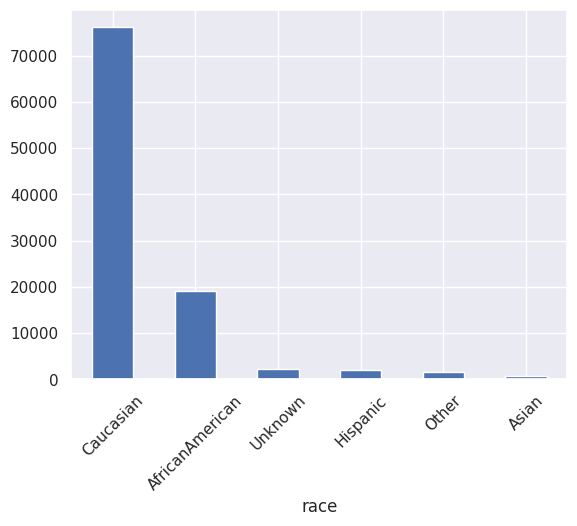

In [25]:
diabetes_df["race"].value_counts().plot(kind='bar', rot=45);

#### Gender

In [27]:
diabetes_df["gender"].value_counts()

gender
Female             54708
Male               47055
Unknown/Invalid        3
Name: count, dtype: int64

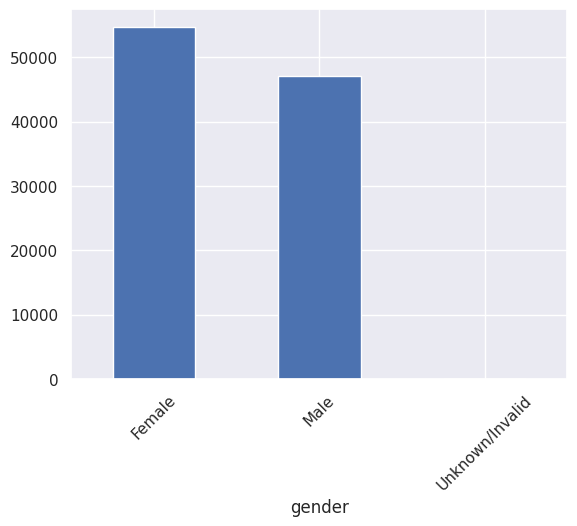

In [28]:
diabetes_df["gender"].value_counts().plot(kind='bar', rot=45);